https://www.cl.cam.ac.uk/teaching/2021/LE49/probnn/3-3.pdf

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
n = 10000

rng = np.random.default_rng(5)

#x1 = np.linspace(-10, 10, n)
#x2 = np.linspace(-10, 10, n)

x1 = rng.normal(0, 1, size=n)
x2 = rng.normal(3, 2.2, size=n)


beta0_true = -0.4
beta1_true = -5.3
beta2_true = 3.1

p = 1/(1+np.exp(-(beta0_true + beta1_true*x1 + beta2_true*x2)))


#y = np.random.binomial(1, p, size=n)
y = rng.binomial(1, p, size=n)

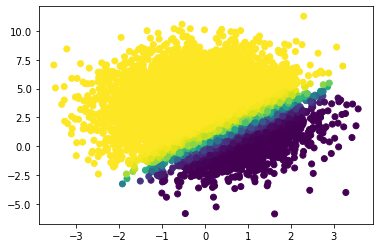

In [3]:
plt.scatter(x1, x2, c=p)

In [4]:
test = np.ones([3,3])

#newcol = np.array([1,2,3])
newcol = 2*np.ones([test.shape[1]])

np.column_stack((test, newcol))

array([[1., 1., 1., 2.],
       [1., 1., 1., 2.],
       [1., 1., 1., 2.]])

In [5]:
x = np.column_stack((x1, x2))

In [6]:
torch.from_numpy(np.ones([3,3])).shape[1]

3

In [7]:
test = nn.Parameter()

In [8]:
test.shape

torch.Size([0])

In [9]:
class LogReg(nn.Module):
    def __init__(self, nfeat):
        super().__init__()
        
        self.nfeat = nfeat
        self.beta = nn.Parameter(torch.zeros([nfeat+1], dtype=torch.float))
        
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)#.type(torch.LongTensor)
        
        #self.f = torch.einsum('ij,j->i', x, self.beta)
        self.f = x @ self.beta
        
        #self.p = 1/(1+torch.exp(-self.f))
        #return y*torch.log(self.p) + (1-y)*torch.log(1-self.p)
        
        stablelogisticloss = nn.BCEWithLogitsLoss()
        return stablelogisticloss(self.f, y.float())
    
    def predict_proba(self, xtest):
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, self.nfeat])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
        #return (1/(1+torch.exp(-(self.beta0 + self.beta1*xtest)))).detach().numpy().flatten()

In [10]:
x[10:12,:]

array([[ 0.27276878,  4.13513209],
       [-1.23332866,  1.72317211]])

In [11]:
np.column_stack((x[10:12,:], np.ones([x[10:12,:].shape[0]])))

array([[ 0.27276878,  4.13513209,  1.        ],
       [-1.23332866,  1.72317211,  1.        ]])

In [12]:
x[10,:].shape

(2,)

In [13]:
len(x[10,:].shape)

1

In [14]:
len(x[10,:].reshape([1,2]).shape)

2

In [15]:
test = x[10,:]
test = test[np.newaxis,:]

In [16]:
np.column_stack((test, np.ones(test.shape[0])))

array([[0.27276878, 4.13513209, 1.        ]])

In [17]:
np.column_stack((x[10,:], np.ones([x[10,:].shape[0]])))

array([[0.27276878, 1.        ],
       [4.13513209, 1.        ]])

In [18]:
model = LogReg(nfeat=x.shape[1])

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [20]:
for _ in range(1000):
    optimizer.zero_grad()
    loss = model(x, y)
    #mean_loss = -torch.mean(loss)
    #mean_loss.backward()
    loss.backward()
    optimizer.step()

In [21]:
loss

tensor(0.0831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [22]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([-5.6855,  3.3199, -0.4248])


In [23]:
(beta1_true, beta2_true, beta0_true)

(-5.3, 3.1, -0.4)

In [24]:
model.predict_proba(x[696,:])

array([0.69176024], dtype=float32)

In [25]:
p[696]

0.6784433923014701

In [26]:
ntest = int(np.floor(n/10))

x1test = rng.normal(0, 1, size=ntest)
x2test = rng.normal(3, 2.2, size=ntest)

ptest = 1/(1+np.exp(-(beta0_true + beta1_true*x1test + beta2_true*x2test)))

xtest = np.column_stack((x1test, x2test))

ytest = rng.binomial(1, ptest, size=ntest)

In [27]:
thresh = 0.5

phat = model.predict_proba(xtest)
yhat = (phat >= thresh).astype(int)

In [28]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(ytest, yhat)
rec = recall_score(ytest, yhat)

(prec, rec)

(0.9803012746234068, 0.986013986013986)

Use logistic regression to set initialisation values, since non-convexity of problem otherwise might be the cause of beta1 being zero and the decision boundary being non-sensical (since beta values currently initialized to 0).

In [29]:
(beta1_true, beta2_true, beta0_true)

(-5.3, 3.1, -0.4)

The version of the model below initialised its parameters to zero, which given that the loss is non-convex, resulted in sometimes parameters staying at zero.  

Modified this model below to initialise using the logistic regression best fit values, which should be a much more sensible starting point.

class LogRegMaxRecall(nn.Module):
    def __init__(self, nfeat, min_prec=0.8, lam=1e4, lr=1e-3):
        super().__init__()
        #self.beta0 = nn.Parameter(torch.tensor(0, dtype=torch.float))
        #self.beta1 = nn.Parameter(torch.tensor(1, dtype=torch.float))
        self.nfeat = nfeat
        self.min_prec = min_prec
        self.beta = nn.Parameter(torch.zeros([nfeat+1], dtype=torch.float))
        
        #Page 6 of paper, second-to-last paragraph
        self.lmbda = lam
                
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)#.type(torch.LongTensor)
        
        #Paragraph below eqn 14 in paper
        self.gamma = torch.tensor(7.)
        self.delta = torch.tensor(0.035)
        
        #self.f = self.beta0 + self.beta1*x
        self.f = x @ self.beta
        
        #self.p = 1/(1+torch.exp(-self.f))
        
        #Eqn 11 in paper
        tpc = torch.sum(torch.where(y==1., self.gamma*self.delta + torch.where(self.f>0., torch.tensor(1.), torch.tensor(0.)), torch.tensor(0.)))
        #tpc.requires_grad = True
        #Why the torch.tensor() on the scalars is needed:
        #https://github.com/pytorch/pytorch/issues/9190#issuecomment-402837158
        
        #print(tpc)
        
        #Paragraph below eqn. 10
        self.mhat = 6.85
        self.bhat = 1.59
        
        #Line below eqn. 1 in paper
        self.Nplus = torch.sum(y)
        
        #Eqn 10
        fpc = torch.sum(torch.where(y==0., (1+self.gamma*self.delta)*torch.sigmoid(self.mhat*self.f+self.bhat), torch.tensor(0.)))
        
        g = -tpc + self.min_prec/(1.-self.min_prec)*fpc + self.gamma*self.delta*self.Nplus
        
        #logitloss = y*torch.log(self.p) + (1-y)*torch.log(1-self.p)
        #stablelogisticloss = nn.BCEWithLogitsLoss()
        #return stablelogisticloss(self.f, y.float())
        
        #Eqn. 12
        loss = -tpc + self.lmbda*nn.ReLU()(g)
        #The reason for the odd way of calling the ReLU function:
        #https://discuss.pytorch.org/t/multiplication-of-activation-function-with-learnable-parameter-scalar/113746/2
        
        return loss
    
    def predict_proba(self, xtest):
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, self.nfeat])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
        #xtest = torch.from_numpy(xtest)
        #return (1/(1+torch.exp(-(self.beta0 + self.beta1*xtest)))).detach().numpy().flatten()

In [30]:
from sklearn.linear_model import LogisticRegression

sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(x,y)
sklearnbetas = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])
sklearnbetas

array([-5.41077869,  3.16822326, -0.40097266])

In [31]:
class LogRegMaxRecall(nn.Module):
    def __init__(self, x, y, min_prec=0.8, lam=1e4):
        super().__init__()
        #self.beta0 = nn.Parameter(torch.tensor(0, dtype=torch.float))
        #self.beta1 = nn.Parameter(torch.tensor(1, dtype=torch.float))
        
        #self.nfeat = nfeat
        self.min_prec = min_prec
        
        #self.beta = nn.Parameter(torch.zeros([nfeat+1], dtype=torch.float))
        sklearnlogreg = LogisticRegression()
        sklearnlogreg = sklearnlogreg.fit(x,y)
        sklearnbetas = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])
        
        self.beta = nn.Parameter(torch.from_numpy(sklearnbetas).float())

        #Page 6 of paper, second-to-last paragraph
        self.lmbda = lam
                
    def forward(self, x, y):
        x = np.column_stack((x, np.ones([x.shape[0]])))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y)#.type(torch.LongTensor)
        
        #Paragraph below eqn 14 in paper
        self.gamma = torch.tensor(7.)
        self.delta = torch.tensor(0.035)
        
        #self.f = self.beta0 + self.beta1*x
        self.f = x @ self.beta
        
        #self.p = 1/(1+torch.exp(-self.f))
        
        #Eqn 11 in paper
        #tpc = torch.sum(torch.where(y==1., self.gamma*self.delta + torch.where(self.f>0., torch.tensor(1.), torch.tensor(0.)), torch.tensor(0.)))
        #Why the torch.tensor() on the scalars is needed:
        #https://github.com/pytorch/pytorch/issues/9190#issuecomment-402837158
        
        self.mtilde = 6.85
        self.btilde = -3.54
        
        #Eqn. 14
        tpc = torch.sum(torch.where(y==1., (1+self.gamma*self.delta)*torch.sigmoid(self.mtilde*self.f+self.btilde), torch.tensor(0.)))
        
        #print(tpc)
        
        #Paragraph below eqn. 10
        self.mhat = 6.85
        self.bhat = 1.59
        
        #Eqn 10
        fpc = torch.sum(torch.where(y==0., (1+self.gamma*self.delta)*torch.sigmoid(self.mhat*self.f+self.bhat), torch.tensor(0.)))
        
        #Line below eqn. 1 in paper
        self.Nplus = torch.sum(y)
        
        #Eqn. 12
        g = -tpc + self.min_prec/(1.-self.min_prec)*fpc + self.gamma*self.delta*self.Nplus
        
        #logitloss = y*torch.log(self.p) + (1-y)*torch.log(1-self.p)
        #stablelogisticloss = nn.BCEWithLogitsLoss()
        #return stablelogisticloss(self.f, y.float())
        
        #Eqn. 12
        loss = -tpc + self.lmbda*nn.ReLU()(g)
        #The reason for the odd way of calling the ReLU function:
        #https://discuss.pytorch.org/t/multiplication-of-activation-function-with-learnable-parameter-scalar/113746/2
        
        return loss
    
    def predict_proba(self, xtest):
        if len(xtest.shape) == 1:
            xtest = xtest.reshape([1, x.shape[0]])
        
        xtest = np.column_stack((xtest, np.ones([xtest.shape[0]])))
        xtest = torch.from_numpy(xtest).float()
        
        f = xtest @ self.beta
        return torch.sigmoid(f).detach().numpy().flatten()
        #xtest = torch.from_numpy(xtest)
        #return (1/(1+torch.exp(-(self.beta0 + self.beta1*xtest)))).detach().numpy().flatten()

In [32]:
model2 = LogRegMaxRecall(x, y, min_prec=0.8)

optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)

In [33]:
for _ in range(100):
    optimizer2.zero_grad()
    loss2 = model2(x, y)
    #loss2 = Variable(loss2, requires_grad=True)
    #mean_loss2 = -torch.mean(loss2)
    #mean_loss2.backward()
    loss2.backward()
    optimizer2.step()

In [34]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([-5.3125,  3.2652, -0.3025])


In [35]:
thresh2 = 0.5

phat2 = model2.predict_proba(xtest)
yhat2 = (phat2 >= thresh2).astype(int)

In [36]:
from sklearn.metrics import precision_score, recall_score

prec2 = precision_score(ytest, yhat2)
rec2 = recall_score(ytest, yhat2)

(prec2, rec2)

(0.9769319492502884, 0.9871794871794872)

In [37]:
loss

tensor(0.0831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

Fitting a perfectly specified model is not a typical use case of this algorithm.  
Let's try different datasets.

### A 1D dataset

In [38]:
from sklearn.datasets import make_classification

xsk, ysk = make_classification(n_samples=10000, n_features=1, n_informative=1, n_redundant=0, n_classes=2, n_clusters_per_class=1, class_sep=2., random_state=6)

In [39]:
ysk.dtype

dtype('int64')

In [40]:
ysk[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

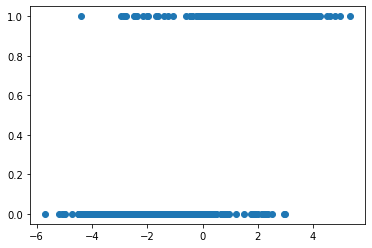

In [41]:
plt.scatter(xsk, ysk)

In [42]:
xsk_train = xsk[:9000]
ysk_train = ysk[:9000]

xsk_test = xsk[9000:]
ysk_test = ysk[9000:]

In [43]:
ysk_train

array([1, 0, 1, ..., 1, 0, 0])

In [44]:
model = LogReg(nfeat=xsk_train.shape[1])

optimizer = optim.Adam(model.parameters(), lr=0.1)

In [45]:
for _ in range(1000):
    optimizer.zero_grad()
    loss = model(xsk_train, ysk_train)
    #mean_loss = -torch.mean(loss)
    #mean_loss.backward()
    loss.backward()
    optimizer.step()

In [46]:
loss

tensor(0.0487, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [47]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([ 3.5631, -0.3246])


In [48]:
psk_hat = model.predict_proba(xsk_test)

In [49]:
thresh = 0.5

ysk_hat = (psk_hat > thresh).astype(int)
ysk_hat[:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

In [50]:
prec = precision_score(ysk_test, ysk_hat)
rec = recall_score(ysk_test, ysk_hat)

(prec, rec)

(0.9842829076620825, 0.9842829076620825)

In [51]:
(ysk_hat != ysk_test).sum()

16

Precision and recall scores are identical. Possibly fine, but slightly suspicious. Manually check them.

In [52]:
((ysk_hat==1) & (ysk_hat==ysk_test)).sum()/len(ysk_hat[ysk_hat==1])

0.9842829076620825

In [53]:
((ysk_hat==1) & (ysk_hat==ysk_test)).sum()/len(ysk_test[ysk_test==1])

0.9842829076620825

They are the same because the denominators are equal: there are the same number of predicted positives as there are of total positives. (And the numerator is the same in both by definition: number of true positives).

In [54]:
#model2 = LogRegMaxRecall(nfeat=xsk_train.shape[1], min_prec=0.8)
model2 = LogRegMaxRecall(xsk_train, ysk_train, min_prec=0.8)

optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)

In [55]:
for _ in range(100):
    optimizer2.zero_grad()
    loss2 = model2(xsk_train, ysk_train)
    #mean_loss2 = -torch.mean(loss2)
    #mean_loss2.backward()
    loss2.backward()
    optimizer2.step()

In [56]:
loss2

tensor(-5522.3608, grad_fn=<AddBackward0>)

In [57]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([ 3.6089, -0.2199])


In [58]:
thresh2 = 0.5

phat2 = model2.predict_proba(xsk_test)
yhat2 = (phat2 >= thresh2).astype(int)

In [59]:
from sklearn.metrics import precision_score, recall_score

prec2 = precision_score(ysk_test, yhat2)
rec2 = recall_score(ysk_test, yhat2)

(prec2, rec2)

(0.982421875, 0.9882121807465619)

### Moons dataset

In [60]:
from sklearn.datasets import make_moons

xmoons, ymoons = make_moons(n_samples = 10000, noise=0.1, random_state=7)

In [61]:
xmoons_train = xmoons[:9000]
ymoons_train = ymoons[:9000]

xmoons_test = xmoons[9000:]
ymoons_test = ymoons[9000:]

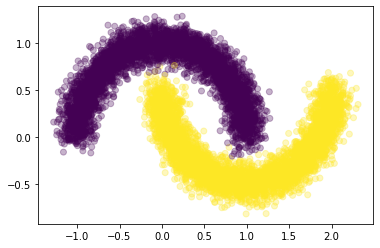

In [62]:
plt.scatter(xmoons_train[:,0], xmoons_train[:,1], c=ymoons_train, alpha=0.3)

To plot decision boundary solve this equation for x, and evaluate it at p=0.5 (the chosen decision threshold):  
$$p = \frac{1}{1+\exp({-x\beta})}$$

$$x\beta = -\ln\left( \frac{1}{p} - 1\right)$$
(Note that for $p=0.5$ this gives $x\beta = 0$)

In [63]:
model = LogReg(nfeat=xmoons_train.shape[1])

In [64]:
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [65]:
for _ in range(1000):
    optimizer.zero_grad()
    loss = model(xmoons_train, ymoons_train)
    #mean_loss = -torch.mean(loss)
    #mean_loss.backward()
    loss.backward()
    optimizer.step()

In [66]:
loss

tensor(0.2457, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [67]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([ 1.1918, -6.0876,  0.9418])


In [68]:
phat = model.predict_proba(xmoons_test)

In [69]:
yhat = (phat >= thresh).astype(int)
yhat[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [70]:
np.unique(yhat, return_counts=True)

(array([0, 1]), array([527, 473]))

In [71]:
betas = [i[1].data.numpy() for i in model.named_parameters() if i[1].requires_grad]
betas = betas[0]
betas

array([ 1.1917762, -6.087632 ,  0.9418012], dtype=float32)

In [72]:
p_thresh = 0.5

x1 = np.linspace(np.min(xmoons), np.max(xmoons), 1000)
x2 = (-np.log(1/p_thresh - 1) -betas[0]*x1 - betas[2])/betas[1]

In [73]:
#fig, ax = plt.subplots()

#ax.scatter(xmoons_test[:,0], xmoons_test[:,1], c=ymoons_test, alpha=0.3)
#ax.plot(x1, x2, c='r')

#plt.plot()

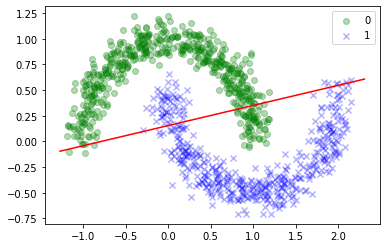

In [74]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(ymoons_test):
    ix = np.where(ymoons_test == g)
    ax.scatter(xmoons_test[ix,0], xmoons_test[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

ax.plot(x1, x2, c='r')

plt.show()

In [75]:
thresh = 0.5

ymoons_hat = (phat > thresh).astype(int)
ymoons_hat[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [76]:
prec = precision_score(ymoons_test, ymoons_hat)
rec = recall_score(ymoons_test, ymoons_hat)

(prec, rec)

(0.8668076109936576, 0.8631578947368421)

In [77]:
#model2 = LogRegMaxRecall(nfeat=xmoons_train.shape[1], min_prec=0.5, lam=10000)
model2 = LogRegMaxRecall(xmoons_train, ymoons_train, min_prec=0.9, lam=1000)

optimizer2 = optim.Adam(model2.parameters(), lr=1e-1)

In [78]:
for _ in range(1000):
    optimizer2.zero_grad()
    loss2 = model2(xmoons_train, ymoons_train)
    #mean_loss2 = -torch.mean(loss2)
    #mean_loss2.backward()
    loss2.backward()
    optimizer2.step()

In [79]:
loss2

tensor(-3551.7317, grad_fn=<AddBackward0>)

In [80]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([ 0.7700, -7.7006, -0.6220])


In [81]:
betas = [i[1].data.numpy() for i in model2.named_parameters() if i[1].requires_grad]
betas = betas[0]
betas

array([ 0.76996815, -7.7006063 , -0.6220269 ], dtype=float32)

In [82]:
p_thresh = 0.5

x1 = np.linspace(np.min(xmoons), np.max(xmoons), 1000)
x2 = (-np.log(1/p_thresh - 1) -betas[0]*x1 - betas[2])/betas[1]

In [83]:
#fig, ax = plt.subplots()

#ax.scatter(xmoons_test[:,0], xmoons_test[:,1], c=ymoons_test, alpha=0.3)
#ax.plot(x1, x2, c='r')
#ax.legend()

#plt.plot()

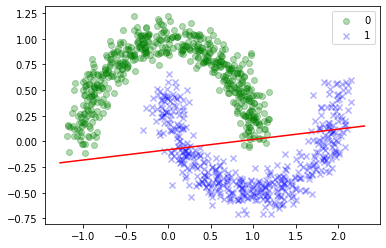

In [84]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(ymoons_test):
    ix = np.where(ymoons_test == g)
    ax.scatter(xmoons_test[ix,0], xmoons_test[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

ax.plot(x1, x2, c='r')

plt.show()

In [85]:
thresh2 = 0.5

phat2 = model2.predict_proba(xmoons_test)
yhat2 = (phat2 >= thresh2).astype(int)

In [86]:
from sklearn.metrics import precision_score, recall_score

prec2 = precision_score(ymoons_test, yhat2)
rec2 = recall_score(ymoons_test, yhat2)

(prec2, rec2)

(0.9854227405247813, 0.7115789473684211)

(0.9854227405247813, 0.7115789473684211)

### Dataset from paper

In [87]:
#https://github.com/tufts-ml/false-alarm-control/blob/main/toy_example_comparing_BCE_Hinge_and_Sigmoid.ipynb

import toydata

x_toy, y_toy, _, _, _, _ = toydata.create_toy_dataset()

In [88]:
x_toy.shape

(570, 2)

In [89]:
y_toy.shape

(570,)

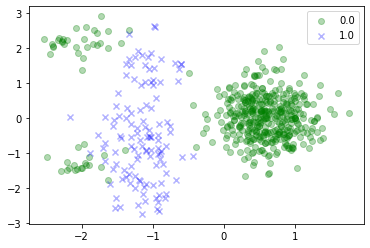

In [90]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(y_toy):
    ix = np.where(y_toy == g)
    ax.scatter(x_toy[ix,0], x_toy[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

#ax.plot(x1, x2, c='r')

plt.show()

In [91]:
y_toy[:200]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Need to shuffle the data before doing train/test split!

In [92]:
idx = np.array(range(y_toy.shape[0]))

rng.shuffle(idx)

In [93]:
idx[:10]

array([482, 299, 214, 101, 243, 199, 153, 379, 157, 537])

In [94]:
xtrain_toy = x_toy[idx[:300]]
ytrain_toy = y_toy[idx[:300]]

xtest_toy = x_toy[idx[300:]]
ytest_toy = y_toy[idx[300:]]

In [95]:
model = LogReg(nfeat=xtrain_toy.shape[1])

optimizer = optim.Adam(model.parameters(), lr=0.1)

In [96]:
for _ in range(1000):
    optimizer.zero_grad()
    loss = model(xtrain_toy, ytrain_toy)
    #mean_loss = -torch.mean(loss)
    #mean_loss.backward()
    loss.backward()
    optimizer.step()

In [97]:
loss

tensor(0.2827, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [98]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([-1.5603, -0.8121, -2.3216])


In [99]:
psk_hat = model.predict_proba(xtest_toy)

In [100]:
betas = [i[1].data.numpy() for i in model.named_parameters() if i[1].requires_grad]
betas = betas[0]
betas

array([-1.5603428, -0.812051 , -2.321582 ], dtype=float32)

In [101]:
p_thresh = 0.5

x1 = np.linspace(np.percentile(xtest_toy, 0), np.percentile(xtest_toy, 95), 1000)
x2 = (-np.log(1/p_thresh - 1) -betas[0]*x1 - betas[2])/betas[1]

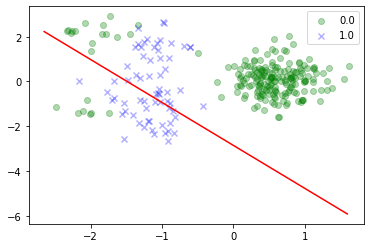

In [102]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(ytest_toy):
    ix = np.where(ytest_toy == g)
    ax.scatter(xtest_toy[ix,0], xtest_toy[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

ax.plot(x1, x2, c='r')

plt.show()

In [103]:
thresh = 0.5

ysk_hat = (psk_hat > thresh).astype(int)
ysk_hat[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [104]:
prec = precision_score(ytest_toy, ysk_hat)
rec = recall_score(ytest_toy, ysk_hat)

(prec, rec)

(0.8108108108108109, 0.45454545454545453)

In [105]:
#model2 = LogRegMaxRecall(nfeat=xtrain_toy.shape[1], min_prec=0.8, lam=10000)
model2 = LogRegMaxRecall(xtrain_toy, ytrain_toy, min_prec=0.85, lam=10000)

optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)

In [106]:
for _ in range(1000):
    optimizer2.zero_grad()
    loss2 = model2(xtrain_toy, ytrain_toy)
    #mean_loss2 = -torch.mean(loss2)
    #mean_loss2.backward()
    loss2.backward()
    optimizer2.step()

In [107]:
loss2

tensor(728091.5952, dtype=torch.float64, grad_fn=<AddBackward0>)

In [108]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name, param.data)

beta tensor([-1.5580, -1.2451, -2.0483])


In [109]:
betas = [i[1].data.numpy() for i in model2.named_parameters() if i[1].requires_grad]
betas = betas[0]
betas

array([-1.5579758, -1.2451404, -2.048286 ], dtype=float32)

In [110]:
p_thresh = 0.5

x1 = np.linspace(np.percentile(xtest_toy, 0), np.percentile(xtest_toy, 95), 1000)
x2 = (-np.log(1/p_thresh - 1) -betas[0]*x1 - betas[2])/betas[1]

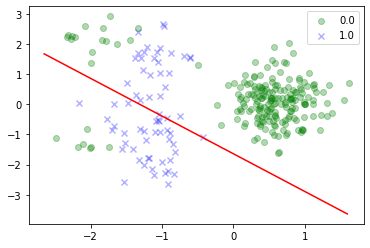

In [111]:
cdict = {0: 'green', 1: 'blue'}
mdict = {0:'o', 1:'x'}

fig, ax = plt.subplots()
for g in np.unique(ytest_toy):
    ix = np.where(ytest_toy == g)
    ax.scatter(xtest_toy[ix,0], xtest_toy[ix,1], c = cdict[g], marker=mdict[g], label = g, alpha=0.3)
ax.legend()

ax.plot(x1, x2, c='r')

plt.show()

In [112]:
thresh2 = 0.5

phat2 = model2.predict_proba(xtest_toy)
yhat2 = (phat2 >= thresh2).astype(int)

In [113]:
from sklearn.metrics import precision_score, recall_score

prec2 = precision_score(ytest_toy, yhat2)
rec2 = recall_score(ytest_toy, yhat2)

(prec2, rec2)

(0.8372093023255814, 0.5454545454545454)